In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import os
import string
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xarray as xr

import torch
import torch.nn as nn
import joblib

sys.path.append('/home/sachin/miniconda3/envs/torch_env/') #sever
from esn_dts_openloop import ESN, Tikhonov

In [2]:
mlp_pot_id = "100pct_3day-removed"
mlp_pot_path = f"/home/sachin/Documents/NIPR/Research/Data/ML/MLP/{mlp_pot_id}_outputs"

mlp_x_id = "x-cond-3day"
mlp_x_path = f"/home/sachin/Documents/NIPR/Research/Data/ML/MLP/{mlp_x_id}_outputs"

mlp_y_id = "y-cond-3day"
mlp_y_path = f"/home/sachin/Documents/NIPR/Research/Data/ML/MLP/{mlp_y_id}_outputs"

mlp_xy_id = 'xy-cond-3day'
mlp_xy_path = f"/home/sachin/Documents/NIPR/Research/Data/ML/MLP/{mlp_xy_id}_outputs"

In [3]:
class MonteCarloDropout(nn.Dropout):
    def forward(self, input):
        return nn.functional.dropout(input, self.p, True, self.inplace)

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, 2056),
            nn.ReLU(),
            #MonteCarloDropout(0.2),
            nn.Linear(2056, 1024),
            nn.ReLU(),
            #MonteCarloDropout(0.2), 
	        nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            MonteCarloDropout(0.2), 
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x)

In [4]:
model_pot = MLP(10)
model_pot.load_state_dict(torch.load(f'{mlp_pot_path}/model_{mlp_pot_id}.pt'))
model_pot.eval()

model_x = MLP(10)
model_x.load_state_dict(torch.load(f'{mlp_x_path}/model_{mlp_x_id}.pt'))
model_x.eval()

model_y = MLP(10)
model_y.load_state_dict(torch.load(f'{mlp_y_path}/model_{mlp_y_id}.pt'))
model_y.eval()

model_xy = MLP(10)
model_xy.load_state_dict(torch.load(f'{mlp_xy_path}/model_{mlp_xy_id}.pt'))
model_xy.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=2056, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2056, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): MonteCarloDropout(p=0.2, inplace=False)
    (11): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [31]:
#Load omni data
omni_data = pd.read_csv('/home/sachin/Documents/NIPR/Research/Data/OMNI/omni_hro_5min_1999-10.csv')
#omni_data = omni_data[omni_data['Timestamp_1min_omni'] == '1999-10-01 00:00:00']
#omni_data = omni_data[omni_data['Timestamp_1min_omni'].between('1999-10-01 00:00:00', '1999-10-07 23:55:00')]
omni_data

#mean over 1 hr 
omni_data['Timestamp_1min_omni'] = pd.to_datetime(omni_data['Timestamp_1min_omni'])
omni_data = omni_data.set_index('Timestamp_1min_omni')
omni_data = omni_data.resample('1h').mean(numeric_only=True)
omni_data = omni_data.reset_index()
omni_data

,Timestamp_1min_omni,BY_GSE,BZ_GSE,flow_speed,proton_density,AE_INDEX,AL_INDEX,AU_INDEX,F10.7,Kp,tilt_angle
0,1999-10-01 00:00:00,2.863333,0.137500,485.200002,4.585000,263.166667,-180.750000,82.500000,121.900002,23.0,-0.135239
1,1999-10-01 01:00:00,2.320833,0.670000,477.366666,4.392500,141.500000,-78.000000,63.666667,121.900002,23.0,-0.174529
2,1999-10-01 02:00:00,3335.558333,3334.116667,33642.833330,336.086667,161.250000,-83.500000,77.833333,121.900002,23.0,-0.205516
3,1999-10-01 03:00:00,3.257500,0.028333,478.166669,3.372500,198.916667,-115.083333,84.000000,121.900002,27.0,-0.225975
4,1999-10-01 04:00:00,3.546667,0.398333,470.924998,3.245833,360.916667,-208.083333,153.000000,121.900002,27.0,-0.234397
...,...,...,...,...,...,...,...,...,...,...,...
739,1999-10-31 19:00:00,-5.975833,2.849167,401.416672,11.745000,79.666667,-29.166667,50.333333,158.100006,17.0,-0.115236
740,1999-10-31 20:00:00,-6.591667,1.051667,407.091667,12.076667,101.666667,-43.166667,58.333333,158.100006,17.0,-0.151877
741,1999-10-31 21:00:00,-8.782500,1.635833,414.616669,9.730833,71.250000,-16.500000,54.833333,158.100006,30.0,-0.194926
742,1999-10-31 22:00:00,-4.645833,-3.884167,430.816671,11.453333,121.250000,-39.250000,82.166667,158.100006,30.0,-0.241651


In [32]:
def split_to_df(df):

    df = df.copy()

    #filters
    df = df[df['BY_GSE'] < 100]
    df = df[df['BZ_GSE'] < 100]
    df = df[df['flow_speed'] < 1400]
    df = df[df['proton_density'] < 150]
    df = df[df['F10.7'] < 400]
    df = df[df['Kp'] < 100]
    df['Kp'] = df['Kp'] / 10

    #change data types
    df[['F10.7','flow_speed']] = df[['F10.7','flow_speed']].astype(int)

    #create grid of lat and lon
    lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
    lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

    lat_mesh, lon_mesh = np.meshgrid(lat, lon)
    lats = lat_mesh.flatten()
    lons = lon_mesh.flatten()

    #expand out df to lat and lon dims. Aka repeat values 
    expanded_df = pd.DataFrame({'lat': lats.repeat(len(df)), 
                                'lon': lons.repeat(len(df)),
                                'BY_GSE': np.tile(df['BY_GSE'], len(lat)*len(lon)),
                                'BZ_GSE': np.tile(df['BZ_GSE'], len(lat)*len(lon)),
                                'flow_speed': np.tile(df['flow_speed'], len(lat)*len(lon)),
                                'proton_density': np.tile(df['proton_density'], len(lat)*len(lon)),
                                'tilt_angle': np.tile(df['tilt_angle'], len(lat)*len(lon)),
                                'dt': np.tile(df['Timestamp_1min_omni'], len(lat)*len(lon)),
                                'F10.7': np.tile(df['F10.7'], len(lat)*len(lon)),
                                'Kp': np.tile(df['Kp'], len(lat)*len(lon)),
                                'AE_INDEX': np.tile(df['AE_INDEX'], len(lat)*len(lon)),
                                'AL_INDEX': np.tile(df['AL_INDEX'], len(lat)*len(lon)),
                                'AU_INDEX': np.tile(df['AU_INDEX'], len(lat)*len(lon))})

    expanded_df['mlt'] = np.mod(expanded_df['lon'] + 12, 360) / 15


    df_2 = expanded_df.copy()
    df_2 = df_2[['dt','mlt','lon','lat','BY_GSE','BZ_GSE','flow_speed','proton_density','tilt_angle']]

    df_2['mlt_sin'] = np.sin(df_2['mlt']*(2.*np.pi/24))
    df_2['mlt_cos'] = np.cos(df_2['mlt']*(2.*np.pi/24))

    df_2['lon_sin'] = np.sin((df_2['lon']-1)*(2.*np.pi/360))
    df_2['lon_cos'] = np.cos((df_2['lon']-1)*(2.*np.pi/360))

    df_2 = df_2.drop(columns=['dt'])

    df_esn = expanded_df.copy()
    df_esn = df_esn[['dt','lat','lon','BY_GSE','BZ_GSE','flow_speed','proton_density','tilt_angle']]
    
    return expanded_df, df_2, df_esn

df_raw, df_proc, df_esn = split_to_df(omni_data)
df_esn


,dt,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle
0,1999-10-01 00:00:00,53.1,1.6,2.863333,0.137500,485,4.585000,-0.135239
1,1999-10-01 01:00:00,53.1,1.6,2.320833,0.670000,477,4.392500,-0.174529
2,1999-10-01 03:00:00,53.1,1.6,3.257500,0.028333,478,3.372500,-0.225975
3,1999-10-01 04:00:00,53.1,1.6,3.546667,0.398333,470,3.245833,-0.234397
4,1999-10-01 05:00:00,53.1,1.6,2.336667,-0.762500,472,3.737500,-0.230160
...,...,...,...,...,...,...,...,...
1703995,1999-10-31 19:00:00,89.7,357.6,-5.975833,2.849167,401,11.745000,-0.115236
1703996,1999-10-31 20:00:00,89.7,357.6,-6.591667,1.051667,407,12.076667,-0.151877
1703997,1999-10-31 21:00:00,89.7,357.6,-8.782500,1.635833,414,9.730833,-0.194926
1703998,1999-10-31 22:00:00,89.7,357.6,-4.645833,-3.884167,430,11.453333,-0.241651


In [7]:
'''
with open(f'{pot_path}/scaler_{pot_id}.pkl', 'rb') as f:
    scaler = pickle.load(f)

col_names = df_proc.columns
norm_arr = scaler.transform(df_proc)
df_proc = pd.DataFrame(norm_arr, columns=col_names)
df_proc = df_proc.drop(columns=['mlt','lon'])
df_proc'''

"\nwith open(f'{pot_path}/scaler_{pot_id}.pkl', 'rb') as f:\n    scaler = pickle.load(f)\n\ncol_names = df_proc.columns\nnorm_arr = scaler.transform(df_proc)\ndf_proc = pd.DataFrame(norm_arr, columns=col_names)\ndf_proc = df_proc.drop(columns=['mlt','lon'])\ndf_proc"

In [33]:
def rescale(df, path, id):

    df = df.copy()
    
    with open(f'{path}/scaler_{id}.pkl', 'rb') as f:
        scaler = pickle.load(f)

    col_names = df.columns
    norm_arr = scaler.transform(df)
    df = pd.DataFrame(norm_arr, columns=col_names)
    df = df.drop(columns=['mlt','lon'])
    
    return df

df_pot = rescale(df_proc, mlp_pot_path, mlp_pot_id)
df_x = rescale(df_proc, mlp_x_path, mlp_x_id)
df_y = rescale(df_proc, mlp_y_path, mlp_y_id)
df_xy = rescale(df_proc, mlp_xy_path, mlp_xy_id)

/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [34]:
def make_predictions(df, model):

    df = df.copy()

    df = df.to_numpy()
    
    df = torch.tensor(df, dtype=torch.float32)

    batch_size = 10000  # Adjust this value based on your system's memory capacity
    n = len(df)
    predictions = []

    for i in range(0, n, batch_size):
        batch = df[i:i+batch_size]
        batch_pred = model(batch).detach().cpu().numpy()
        batch_pred = batch_pred.flatten()
        predictions.extend(batch_pred)

    return predictions

pot_pred = make_predictions(df_pot, model_pot)
x_pred = make_predictions(df_x, model_x)
y_pred = make_predictions(df_y, model_y)
xy_pred = make_predictions(df_xy, model_xy)

df_comp = df_raw
df_comp['mlp_pot'] = pot_pred
df_comp['mlp_x'] = x_pred
df_comp['mlp_y'] = y_pred
df_comp['mlp_xy'] = xy_pred

In [10]:
'''
df_proc = df_proc.to_numpy()
df_proc = torch.tensor(df_proc, dtype=torch.float32)

batch_size = 10000  # Adjust this value based on your system's memory capacity
n = len(df_proc)
predictions = []

for i in range(0, n, batch_size):
    batch = df_proc[i:i+batch_size]
    batch_pred = model_pot(batch).detach().cpu().numpy()
    batch_pred = batch_pred.flatten()
    predictions.extend(batch_pred)

df_raw['potential_pred'] = predictions
df_comp = df_raw
df_comp'''

"\ndf_proc = df_proc.to_numpy()\ndf_proc = torch.tensor(df_proc, dtype=torch.float32)\n\nbatch_size = 10000  # Adjust this value based on your system's memory capacity\nn = len(df_proc)\npredictions = []\n\nfor i in range(0, n, batch_size):\n    batch = df_proc[i:i+batch_size]\n    batch_pred = model_pot(batch).detach().cpu().numpy()\n    batch_pred = batch_pred.flatten()\n    predictions.extend(batch_pred)\n\ndf_raw['potential_pred'] = predictions\ndf_comp = df_raw\ndf_comp"

In [35]:
def filter_by_dt(df):
   df = df.copy()
   #df = df[df['dt']=='1999-10-01 12:00:00']
   
   df = df.sort_values(by=['lat'])
   df = df[df['lat'].between(60, 70)]

   return df

df_filt = filter_by_dt(df_comp)
df_filt

,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,dt,F10.7,Kp,AE_INDEX,AL_INDEX,AU_INDEX,mlt,mlp_pot,mlp_x,mlp_y,mlp_xy
920642,60.672414,195.372152,24.165000,-10.823333,546,15.366667,-0.348423,1999-10-22 06:00:00,158,8.0,417.666667,-446.416667,-28.666667,13.824810,12.235508,2.607529,2.030222,1.658176
920626,60.672414,195.372152,-17.845833,-0.898333,448,10.410000,-0.057939,1999-10-21 13:00:00,157,1.7,153.000000,-45.916667,107.000000,13.824810,-9.052841,5.649491,5.363634,7.222396
920627,60.672414,195.372152,-16.391667,-1.232500,463,8.552500,-0.029325,1999-10-21 14:00:00,157,1.7,130.750000,-26.916667,103.916667,13.824810,-0.357116,5.070482,4.745302,7.160650
920641,60.672414,195.372152,12.059167,-28.270000,528,8.691667,-0.366461,1999-10-22 05:00:00,158,7.7,794.416667,-794.000000,0.583333,13.824810,-1.598838,2.372291,3.366358,1.455068
920640,60.672414,195.372152,7.327500,-27.581667,525,6.491667,-0.371980,1999-10-22 04:00:00,158,7.7,1110.416667,-1243.500000,-132.916667,13.824810,9.181809,2.674749,2.942605,1.625154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73151,69.506897,15.118987,3.560000,0.071667,441,5.520833,-0.049855,1999-10-01 22:00:00,121,1.3,142.250000,-89.000000,53.250000,1.807932,-16.303852,1.694158,1.626276,1.662297
73136,69.506897,15.118987,0.971667,1.801667,471,3.886667,-0.186006,1999-10-01 07:00:00,121,1.3,163.500000,-81.333333,82.083333,1.807932,-12.726228,1.655378,1.623630,1.640591
73137,69.506897,15.118987,-0.321667,1.032500,471,4.129167,-0.149395,1999-10-01 08:00:00,121,1.3,83.916667,-24.166667,59.583333,1.807932,-19.495827,1.649875,1.624136,1.626674
1521530,69.506897,321.549367,2.863333,0.137500,485,4.585000,-0.135239,1999-10-01 00:00:00,121,2.3,263.166667,-180.750000,82.500000,22.236624,13.426201,1.655152,1.624136,1.641100


KeyError: 'pot_pred'

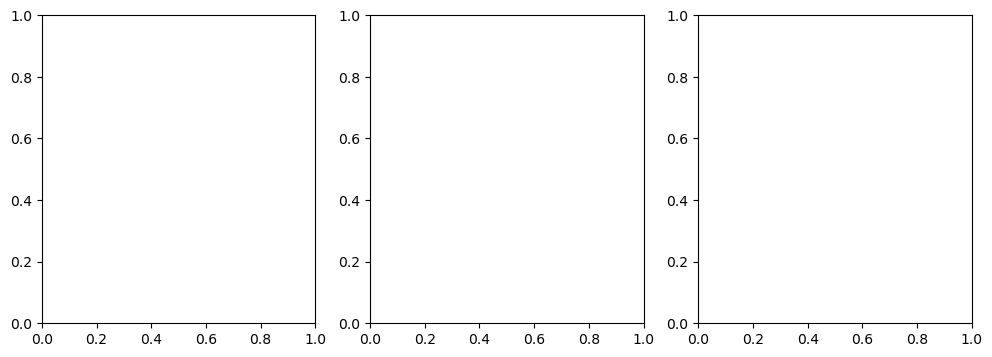

In [12]:
#plot pot_pred, x_pred, y_pred 
figs, axs = plt.subplots(1, 3, figsize=(12, 4))

sns.histplot(df_filt['pot_pred'], ax=axs[0], bins=50)
axs[0].set_title('Potential Prediction')
axs[0].set_xlabel('Potential Prediction')
axs[0].set_ylabel('Frequency')

sns.histplot(df_filt['x_pred'], ax=axs[1], bins=50)
axs[1].set_title('X Prediction')
axs[1].set_xlabel('X Prediction')
axs[1].set_ylabel('Frequency')

sns.histplot(df_filt['y_pred'], ax=axs[2], bins=50)
axs[2].set_title('Y Prediction')
axs[2].set_xlabel('Y Prediction')
axs[2].set_ylabel('Frequency')

plt.tight_layout()

ESN

In [36]:
def load_esn(df):

    df = df.copy()
    df['dt'] = pd.to_datetime(df['dt'])
    df = df.set_index(['dt','lat','lon'])
    ds = df.to_xarray()
    
    ds['BY_GSE'] = ds['BY_GSE'].mean(dim=['lat', 'lon'])
    ds['BZ_GSE'] = ds['BZ_GSE'].mean(dim=['lat', 'lon'])
    ds['flow_speed'] = ds['flow_speed'].mean(dim=['lat', 'lon'])
    ds['proton_density'] = ds['proton_density'].mean(dim=['lat', 'lon'])
    ds['tilt_angle'] = ds['tilt_angle'].mean(dim=['lat', 'lon'])

    def load_model_pca(parameter, id):
        
        with open(f'/home/sachin/Documents/NIPR/Research/Data/ESN/models/SMRAI2_{parameter}_ID{id}.pkl', 'rb') as f:
            model = pickle.load(f)

        
        pca_reload = pickle.load(open(f'/home/sachin/Documents/NIPR/Research/Data/ESN/models/ESN_{parameter}_pca_ID{id}.pkl','rb'))

        return model, pca_reload
    
    pot_model, pot_pca = load_model_pca('potential', 25)
    x_model, x_pca = load_model_pca('x-cond', 5)
    y_model, y_pca = load_model_pca('y-cond', 5)
    xy_model, xy_pca = load_model_pca('xy-cond', 5)

    def make_predictions(ds, model, pca):
        ds = ds.copy()
        prediction_arr = ds.to_array().values.T
        prediction = model.predict(prediction_arr)

        prediction_original = pca.inverse_transform(prediction)
        prediction_original = prediction_original.reshape(-1, 30,80)

        return prediction_original

    prediction_potential = make_predictions(ds, pot_model, pot_pca)
    prediction_x = make_predictions(ds, x_model, x_pca)
    prediction_y = make_predictions(ds, y_model, y_pca)
    prediction_xy = make_predictions(ds, xy_model, xy_pca)

    ds['esn_pot'] = (('dt','lat','lon'), prediction_potential)
    ds['esn_x'] = (('dt','lat','lon'), prediction_x)
    ds['esn_y'] = (('dt','lat','lon'), prediction_y)
    ds['esn_xy'] = (('dt','lat','lon'), prediction_xy)

    df = ds.to_dataframe()
    df = df.reset_index()
    df = df[df['lat'].between(60, 70)]

    return df

df_esn = load_esn(df_esn)
df_esn

,dt,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,esn_pot,esn_x,esn_y,esn_xy
480,1999-10-01 00:00:00,60.672414,1.600000,2.863333,0.137500,485.0,4.585000,-0.135239,0.251857,5.866311,5.703008,14.875186
481,1999-10-01 00:00:00,60.672414,6.106329,2.863333,0.137500,485.0,4.585000,-0.135239,-0.354948,5.758116,5.594204,14.518822
482,1999-10-01 00:00:00,60.672414,10.612658,2.863333,0.137500,485.0,4.585000,-0.135239,-0.947539,5.689862,5.524981,14.281898
483,1999-10-01 00:00:00,60.672414,15.118987,2.863333,0.137500,485.0,4.585000,-0.135239,-1.503682,5.615160,5.449630,14.023434
484,1999-10-01 00:00:00,60.672414,19.625316,2.863333,0.137500,485.0,4.585000,-0.135239,-2.025050,5.466593,5.300696,13.523000
...,...,...,...,...,...,...,...,...,...,...,...,...
1702715,1999-10-31 23:00:00,69.506897,339.574684,-3.591667,-0.103333,434.0,10.625833,-0.289042,-0.234532,2.090032,2.048608,3.141700
1702716,1999-10-31 23:00:00,69.506897,344.081013,-3.591667,-0.103333,434.0,10.625833,-0.289042,-1.544903,2.070917,2.029818,3.061345
1702717,1999-10-31 23:00:00,69.506897,348.587342,-3.591667,-0.103333,434.0,10.625833,-0.289042,-2.868344,2.058882,2.017998,3.009123
1702718,1999-10-31 23:00:00,69.506897,353.093671,-3.591667,-0.103333,434.0,10.625833,-0.289042,-4.200899,2.055435,2.014708,2.989111


In [37]:
def calculate_delta(lat1, lon1, lat2, lon2):
    R_E = 6371.0 * 1e3 #meters

    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    delta_x = (dlat / 360)*2*np.pi*R_E
    delta_y = (dlon / 360)*2*np.pi*R_E*np.sin(lat1_rad)

    return delta_x, delta_y

lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

delta_x, delta_y = calculate_delta(lat[0], lon[0], lat[1], lon[1])

In [41]:
def calc_E(df,architecture):

    df = df.copy()

    dx, dy, = delta_x, delta_y #90-50 = 40/30 = 1.33, 360/80 = 4.5

    for dt in df['dt'].unique():
        df_dt = df[df['dt'] == dt]
        #dx, dy = calculate_gradient(df_dt['lat'].values, df_dt['lon'].values)
        grad_x, grad_y = np.gradient(df_dt[f'{architecture}_pot'].values.reshape(8,80), dx, dy) #8 values is for between 60 and 70 lat, otherwise its 30
        grad_x = grad_x.flatten()
        grad_y = grad_y.flatten()
        Ex = -grad_x * 1e3 #mV/m
        Ey = -grad_y * 1e3 #mV/m

        df.loc[df['dt'] == dt, f'{architecture}_Ex'] = Ex
        df.loc[df['dt'] == dt, f'{architecture}_Ey'] = Ey

    #df['Vx'] = df['Ex'] * 40
    #df['Vy'] = df['Ey'] * 40

    df[f'{architecture}_JHx'] = -df[f'{architecture}_xy'] * df[f'{architecture}_Ey'] #east-west
    df[f'{architecture}_JHy'] = df[f'{architecture}_xy'] * df[f'{architecture}_Ex'] #north-south


    df['dt'] = pd.to_datetime(df['dt'])
    df = df.sort_values(by=['dt'])

    return df

df_mlp_E = calc_E(df_filt, 'mlp')
df_esn_E = calc_E(df_esn, 'esn')

<Axes: xlabel='mlp_pot', ylabel='Count'>

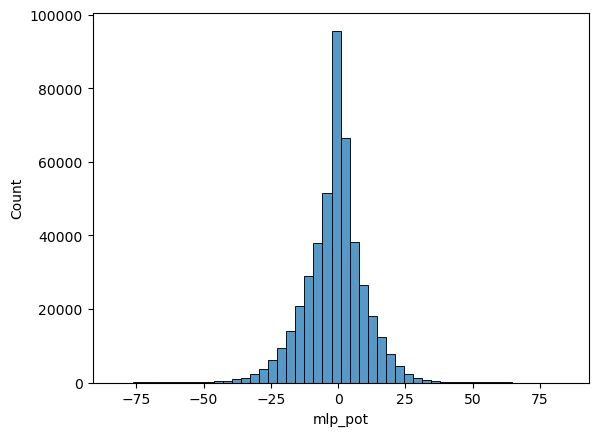

In [42]:
sns.histplot(df_mlp_E['mlp_pot'], bins=50)

<Axes: xlabel='esn_pot', ylabel='Count'>

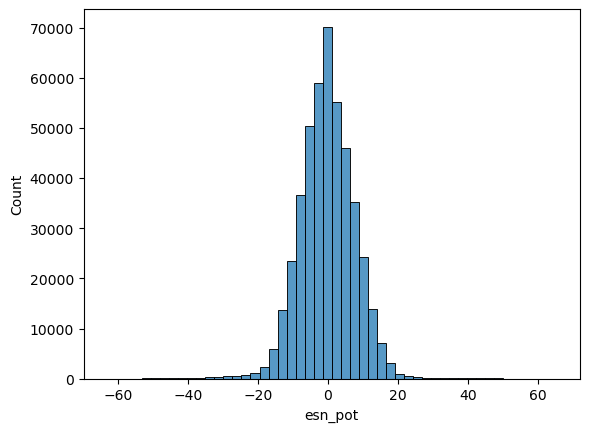

In [43]:
sns.histplot(df_esn_E['esn_pot'], bins=50)

In [ ]:
#Ex = -grad_x
#Ey = -grad_y

#df_filt['Ex'] = Ex.flatten() #north-south
#df_filt['Ey'] = Ey.flatten()  #east-west

#calculate conductivity tensor
#df_filt['sigma_xy'] = df_filt['x_pred'] * df_filt['y_pred']
#df_filt['sigma_xx'] = df_filt['x_pred']**2
#df_filt['sigma_yy'] = df_filt['y_pred']**2
#df_filt['sigma_neg_xy'] = -df_filt['x_pred'] * df_filt['y_pred']

#calculate Hall and Pedersen currents
df_filt['mlp_JHx'] = -df_filt['mlp_xy'] * df_filt['mlp_Ey'] #east-west
df_filt['mlp_JHy'] = df_filt['mlp_xy'] * df_filt['mlp_Ex'] #north-south

#Pederson currents and Joule Heating
#df_filt['JPx'] = df_filt['x_pred'] * df_filt['Ex']
#df_filt['JPy'] = df_filt['y_pred'] * df_filt['Ey']
#df_filt['QJx'] = df_filt['JPx'] * df_filt['Ex']**2
#df_filt['QJy'] = df_filt['JPy'] * df_filt['Ey']**2

df_filt['dt'] = pd.to_datetime(df_filt['dt'])
df_filt

In [44]:
#take maximum value of JHx for each dt and call it JHx_max and the minimum value of JHx for each dt and call it JHx_min. add to new d

df_AU = df_mlp_E.groupby('dt')['AU_INDEX'].mean().reset_index()
df_AU.columns = ['dt','omni_AU']
df_AL = df_mlp_E.groupby('dt')['AL_INDEX'].mean().reset_index()
df_AL.columns = ['dt','omni_AL']

df_JHy_mlp_max = df_mlp_E.groupby('dt')['mlp_JHy'].max().reset_index()
df_JHy_mlp_max.columns = ['dt','mlp_AU']

df_JHy_mlp_min = df_mlp_E.groupby('dt')['mlp_JHy'].min().reset_index()
df_JHy_mlp_min.columns = ['dt','mlp_AL']

df_JHy_esn_max = df_esn_E.groupby('dt')['esn_JHy'].max().reset_index()
df_JHy_esn_max.columns = ['dt','esn_AU']

df_JHy_esn_min = df_esn_E.groupby('dt')['esn_JHy'].min().reset_index()
df_JHy_esn_min.columns = ['dt','esn_AL']

df_ae = pd.merge(df_JHy_mlp_max, df_JHy_mlp_min, on='dt')
df_ae = pd.merge(df_ae, df_AU, on='dt')
df_ae = pd.merge(df_ae, df_AL, on='dt')
df_ae = pd.merge(df_ae, df_JHy_esn_max, on='dt')
df_ae = pd.merge(df_ae, df_JHy_esn_min, on='dt')

df_ae['mlp_AE'] = df_ae['mlp_AU'] - df_ae['mlp_AL']
df_ae['esn_AE'] = df_ae['esn_AU'] - df_ae['esn_AL']
df_ae['omni_ae'] = df_ae['omni_AU'] - df_ae['omni_AL']   
df_ae


,dt,mlp_AU,mlp_AL,omni_AU,omni_AL,esn_AU,esn_AL,mlp_AE,esn_AE,omni_ae
0,1999-10-01 00:00:00,110.588242,-111.350418,82.500000,-180.750000,7.078861,-6.982569,221.938660,14.061430,263.250000
1,1999-10-01 01:00:00,190.560547,-192.383835,63.666667,-78.000000,5.012644,-5.111701,382.944397,10.124346,141.666667
2,1999-10-01 03:00:00,104.002289,-94.229393,84.000000,-115.083333,5.255766,-5.405274,198.231689,10.661041,199.083333
3,1999-10-01 04:00:00,142.855179,-137.160385,153.000000,-208.083333,5.108209,-5.398295,280.015564,10.506504,361.083333
4,1999-10-01 05:00:00,104.161690,-109.594650,125.500000,-113.500000,5.674579,-5.535763,213.756348,11.210341,239.000000
...,...,...,...,...,...,...,...,...,...,...
705,1999-10-31 19:00:00,55.629967,-68.671021,50.333333,-29.166667,4.483904,-2.287887,124.300987,6.771791,79.500000
706,1999-10-31 20:00:00,80.013458,-81.428322,58.333333,-43.166667,5.294487,-2.787149,161.441772,8.081636,101.500000
707,1999-10-31 21:00:00,28.899393,-37.879463,54.833333,-16.500000,5.793738,-2.990500,66.778854,8.784238,71.333333
708,1999-10-31 22:00:00,128.264511,-154.195221,82.166667,-39.250000,8.835436,-5.069481,282.459717,13.904918,121.416667


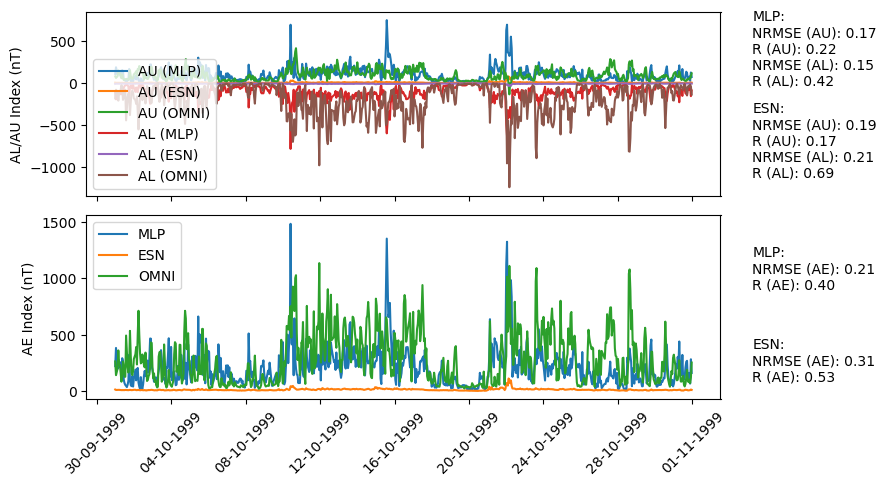

In [51]:
def plot_a_indices():

    fig, ax = plt.subplots(2,1,figsize=(9, 5), sharex=True)

    #RMSE, NRMSE, R for MLP and ESN for AU and AL
    RMSE_MLP_AU = np.sqrt(np.mean((df_ae['mlp_AU'] - df_ae['omni_AU'])**2))
    NRMSE_MLP_AU = RMSE_MLP_AU / (df_ae['omni_AU'].max() - df_ae['omni_AU'].min())
    R_MLP_AU = stats.pearsonr(df_ae['mlp_AU'], df_ae['omni_AU'])[0]
    RMSE_ESN_AU = np.sqrt(np.mean((df_ae['esn_AU'] - df_ae['omni_AU'])**2))
    NRMSE_ESN_AU = RMSE_ESN_AU / (df_ae['omni_AU'].max() - df_ae['omni_AU'].min())
    R_ESN_AU = stats.pearsonr(df_ae['esn_AU'], df_ae['omni_AU'])[0]
    RMSE_MLP_AL = np.sqrt(np.mean((df_ae['mlp_AL'] - df_ae['omni_AL'])**2))
    NRMSE_MLP_AL = RMSE_MLP_AL / (df_ae['omni_AL'].max() - df_ae['omni_AL'].min())
    R_MLP_AL = stats.pearsonr(df_ae['mlp_AL'], df_ae['omni_AL'])[0]
    RMSE_ESN_AL = np.sqrt(np.mean((df_ae['esn_AL'] - df_ae['omni_AL'])**2))
    NRMSE_ESN_AL = RMSE_ESN_AL / (df_ae['omni_AL'].max() - df_ae['omni_AL'].min())
    R_ESN_AL = stats.pearsonr(df_ae['esn_AL'], df_ae['omni_AL'])[0]

    #RMSE, NRMSE, R for MLP and ESN for AE
    RMSE_MLP_AE = np.sqrt(np.mean((df_ae['mlp_AE'] - df_ae['omni_ae'])**2))
    NRMSE_MLP_AE = RMSE_MLP_AE / (df_ae['omni_ae'].max() - df_ae['omni_ae'].min())
    R_MLP_AE = stats.pearsonr(df_ae['mlp_AE'], df_ae['omni_ae'])[0]
    RMSE_ESN_AE = np.sqrt(np.mean((df_ae['esn_AE'] - df_ae['omni_ae'])**2))
    NRMSE_ESN_AE = RMSE_ESN_AE / (df_ae['omni_ae'].max() - df_ae['omni_ae'].min())
    R_ESN_AE = stats.pearsonr(df_ae['esn_AE'], df_ae['omni_ae'])[0]


    ax[0].plot(df_ae['dt'], df_ae['mlp_AU'], label='AU (MLP)')
    ax[0].plot(df_ae['dt'], df_ae['esn_AU'], label='AU (ESN)')
    ax[0].plot(df_ae['dt'], df_ae['omni_AU'], label='AU (OMNI)')
    ax[0].plot(df_ae['dt'], df_ae['mlp_AL'], label='AL (MLP)')
    ax[0].plot(df_ae['dt'], df_ae['esn_AL'], label='AL (ESN)')
    ax[0].plot(df_ae['dt'], df_ae['omni_AL'], label='AL (OMNI)')
    ax[0].set_ylabel('AL/AU Index (nT)')
    ax[0].legend()

    ax[0].text(1.05, 0.6, f'MLP:\nNRMSE (AU): {NRMSE_MLP_AU:.2f}\nR (AU): {R_MLP_AU:.2f}\nNRMSE (AL): {NRMSE_MLP_AL:.2f}\nR (AL): {R_MLP_AL:.2f}', transform=ax[0].transAxes)
    ax[0].text(1.05, 0.1, f'ESN:\nNRMSE (AU): {NRMSE_ESN_AU:.2f}\nR (AU): {R_ESN_AU:.2f}\nNRMSE (AL): {NRMSE_ESN_AL:.2f}\nR (AL): {R_ESN_AL:.2f}', transform=ax[0].transAxes)

    ax[1].plot(df_ae['dt'], df_ae['mlp_AE'], label='MLP')
    ax[1].plot(df_ae['dt'], df_ae['esn_AE'], label='ESN')
    ax[1].plot(df_ae['dt'], df_ae['omni_ae'], label='OMNI')
    ax[1].set_ylabel('AE Index (nT)')
    ax[1].legend()

    #space dates every 7 days
    ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    plt.xticks(rotation=45)

    ax[1].text(1.05, 0.6, f'MLP:\nNRMSE (AE): {NRMSE_MLP_AE:.2f}\nR (AE): {R_MLP_AE:.2f}', transform=ax[1].transAxes)
    ax[1].text(1.05, 0.1, f'ESN:\nNRMSE (AE): {NRMSE_ESN_AE:.2f}\nR (AE): {R_ESN_AE:.2f}', transform=ax[1].transAxes)
    
    plt.tight_layout()
    plt.savefig('MLP_ESN_AE_AL.png', dpi=500)
plot_a_indices()

In [ ]:
sns.histplot(df_filt['QJx']*1e-6, bins=50)

In [ ]:
def polar_plot(df):
    df = df.copy()
    df = df.set_index(['dt','lat','lon'])
    ds = df.to_xarray()

    theta = np.linspace(0, 360, 80) - 90
    theta_rad = theta / 360 * 2 * np.pi
    r = 90 - np.linspace(53.1, 89.7, 30)
    shrink = .5

    fig, ax = plt.subplots(1, 2, figsize=(7, 4), subplot_kw={'projection': 'polar'})

    Qjx = (ds['JPx'].mean('dt').values)
    Qjy = (ds['JPy'].mean('dt').values)

    levels = np.linspace(-20, 20, 40)
    plot = ax[0].contourf(theta_rad, r, Qjx, cmap='bwr', levels=levels, extend='both')
    #ax[0].set_title('Joule Heating East-West')

    plot = ax[1].contourf(theta_rad, r, Qjy, cmap='bwr', levels=levels, extend='both')
    #ax[1].set_title('Joule Heating North-South')

    plt.colorbar(plot, ax=ax, shrink=shrink)
    plt.tight_layout()



    return ds

polar_plot(df_filt)

In [ ]:
def plot_quiver(df):
    df = df.copy()
    df = df.sort_values(by=['lat','lon'])

    df['theta'] = np.radians(df['lon'])
    df['r'] = 90 - df['lat']

    df['Er'] = df['Ex'] * np.cos(df['theta']) + df['Ey'] * np.sin(df['theta'])
    df['Etheta'] = -df['Ex'] * np.sin(df['theta']) + df['Ey'] * np.cos(df['theta'])

    fig, ax = plt.subplots(1, 1, figsize=(5, 5),subplot_kw={'projection': 'polar'})

    ax.quiver(df['theta'], df['r'], df['Er'], df['Etheta'],scale=200)
    #ax.set_title('Electric Field')

    ax.set_ylim([0, 37])
    ax.set_yticks([0, 10, 20, 30])
    ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    ax.set_xlim([-np.pi, np.pi])
    ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 \nMidday", "15", "18 \nDusk"])
    ax.set_title(f'Electric Field \n 1999-10-01 00:00:00')
    #plt.colorbar(c_true, ax=ax, label='Potential (Error) [kV]', shrink=shrink, pad=0.15, ticks=np.arange(0,6,1), orientation='horizontal')
    ax.grid(True, linestyle='-', alpha=0.6)
    #ax.set_theta_direction(-1)

    plt.tight_layout()
    plt.savefig('quiver.png',dpi=300)


    return df.head(5)

plot_quiver(df_filt)